## H2O-3 Classification Tutorial

チュートリアルページ：[**1A. Introduction to Machine Learning with H2O-3 - Classification**](https://training.h2o.ai/products/1a-introduction-to-machine-learning-with-h2o-3-classification)

[**H2O 3 - ドキュメント**](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/index.html)  
[**Python - APIドキュメント**](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/index.html)

目次
- [Initial Setup](#InitialSetup)
- [Start Experiment](#StartExperiment)
- [Build a GLM](#BuildGLM)
- [Build a Random Forest](#BuildRandomForest)
- [Build a GBM](#BuildGBM)
- [Tune the GLM with H2O GridSearch](#TuneGLMGridSearch)
- [Tune the RF model with H2O GridSearch](#TuneRFGridSearch)

***

<a id='InitialSetup'></a>
### Initial Setup

In [1]:
#> H2Oパッケージのインポート
import h2o
print(h2o.__version__)

3.30.1.1


同じバージョンのH2O_3 jarファイルをコマンドプロンプトで実行（Windowsローカル環境で実施）
> h2o-3.30.1.1> java -jar h2o.jar

In [2]:
#> 他利用パッケージと、H2O関連モジュールのインポート
import matplotlib as plt    # H2Oモジュールから呼び出される結果の描画で必要
%matplotlib inline

#Import the Estimators
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

#Import h2o grid search 
import h2o.grid 
from h2o.grid.grid_search import H2OGridSearch

H2Oクラスターの開始

In [3]:
h2o.init(url='http://localhost:54321')

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 hours 6 mins
H2O_cluster_timezone:,Asia/Tokyo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,30 days
H2O_cluster_name:,jpnyvs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.541 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


(to do) データに関して

行数:500,137、列数:27（約80MB）  

[Data Reference] http://www.freddiemac.com/research/datasets/sf_loanlevel_dataset.page

In [4]:
#> データのロード
loan_level = h2o.import_file("https://s3.amazonaws.com/data.h2o.ai/DAI-Tutorials/loan_level_500k.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


***

<a id='StartExperiment'></a>
### Start Experiment

[**Data Manipulation - ドキュメント**](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-munging.html#)

In [5]:
type(loan_level)

h2o.frame.H2OFrame

[**H2OFrame - APIドキュメント**](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html#h2oframe)

In [6]:
#> 最初の10行の表示
loan_level.head()

CREDIT_SCORE,FIRST_PAYMENT_DATE,FIRST_TIME_HOMEBUYER_FLAG,MATURITY_DATE,METROPOLITAN_STATISTICAL_AREA,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,CHANNEL,PREPAYMENT_PENALTY_MORTGAGE_FLAG,PRODUCT_TYPE,PROPERTY_STATE,PROPERTY_TYPE,POSTAL_CODE,LOAN_SEQUENCE_NUMBER,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,SELLER_NAME,SERVICER_NAME,PREPAID,DELINQUENT
669,200206,N,202901,nan,0,1,O,80,33,162000,80,7.12,R,N,FRM,WV,SF,26100,F199Q1000004,P,320,2,Other sellers,Other servicers,TRUE,FALSE
732,199904,N,202903,17140,0,1,O,25,10,53000,25,6.5,R,N,FRM,OH,SF,45200,F199Q1000005,N,360,1,Other sellers,Other servicers,TRUE,FALSE
679,200208,N,202902,15940,30,1,O,91,48,133000,91,6.75,R,N,FRM,OH,SF,44700,F199Q1000007,P,319,1,Other sellers,Other servicers,TRUE,FALSE
721,200209,N,202902,38060,0,1,O,39,13,174000,39,6.625,T,N,FRM,AZ,SF,85200,F199Q1000013,N,318,2,Other sellers,Other servicers,TRUE,FALSE
618,200210,N,202902,10420,25,1,O,85,24,122000,85,6.375,R,N,FRM,OH,SF,44200,F199Q1000015,N,317,2,Other sellers,Other servicers,TRUE,FALSE
738,200211,N,202903,10420,0,1,O,73,44,218000,73,6,R,N,FRM,OH,SF,44300,F199Q1000016,P,317,2,Other sellers,Other servicers,TRUE,FALSE
761,200211,N,202904,nan,0,1,O,73,31,138000,73,6.375,R,N,FRM,SC,PU,29500,F199Q1000017,P,318,2,Other sellers,Other servicers,TRUE,FALSE
707,200211,N,202903,33340,0,1,O,60,57,136000,60,6.25,R,N,FRM,WI,SF,53000,F199Q1000018,C,317,2,Other sellers,Other servicers,TRUE,FALSE
760,200211,N,202903,33340,0,1,O,63,30,79000,63,6.125,R,N,FRM,WI,SF,53000,F199Q1000019,N,317,2,Other sellers,Other servicers,TRUE,FALSE
691,200302,N,202901,15940,0,1,O,65,25,130000,65,5.875,R,N,FRM,OH,SF,44700,F199Q1000023,P,312,2,Other sellers,Other servicers,TRUE,FALSE


In [7]:
#> データのサマリ
loan_level.describe()

Rows:500137
Cols:27




,CREDIT_SCORE,FIRST_PAYMENT_DATE,FIRST_TIME_HOMEBUYER_FLAG,MATURITY_DATE,METROPOLITAN_STATISTICAL_AREA,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,CHANNEL,PREPAYMENT_PENALTY_MORTGAGE_FLAG,PRODUCT_TYPE,PROPERTY_STATE,PROPERTY_TYPE,POSTAL_CODE,LOAN_SEQUENCE_NUMBER,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,SELLER_NAME,SERVICER_NAME,PREPAID,DELINQUENT
type,int,int,enum,int,int,int,int,enum,int,int,int,int,real,enum,enum,enum,enum,enum,int,string,enum,int,int,enum,enum,enum,enum
mins,300.0,199901.0,,202402.0,10180.0,0.0,1.0,,6.0,1.0,8000.0,6.0,4.625,,,,,,600.0,NaN,,301.0,1.0,,,,
mean,712.5362124215463,200025.43095191894,,203023.19587233104,30777.82473929505,7.744531707523449,1.0288902574110141,,76.0535707144628,32.917540518705366,136493.48478516893,75.71071405720134,7.18268686379932,,,,,,55490.85713828671,NaN,,359.85546960132933,1.6302946648262617,,,,
maxs,839.0,201103.0,,204101.0,49740.0,55.0,4.0,,180.0,65.0,578000.0,100.0,11.5,,,,,,99900.0,NaN,,362.0,2.0,,,,
sigma,54.79126197408829,109.81554141516152,,110.3841885573338,11333.401144164458,12.046545969492563,0.21839057355939084,,15.1399860485127,11.111799994455243,60968.74306564565,14.937717088968684,0.5799408623980559,,,,,,29505.382258803038,NaN,,1.908250710418729,0.4827253530403165,,,,
zeros,0,0,,0,0,309979,0,,0,0,0,0,0,,,,,,0,0,,0,0,,,,
missing,2711,0,0,0,70149,51048,3,0,13,14929,0,9,0,0,0,0,0,0,31,0,0,0,247,0,0,0,0
0,669.0,200206.0,N,202901.0,nan,0.0,1.0,O,80.0,33.0,162000.0,80.0,7.12,R,N,FRM,WV,SF,26100.0,F199Q1000004,P,320.0,2.0,Other sellers,Other servicers,TRUE,FALSE
1,732.0,199904.0,N,202903.0,17140.0,0.0,1.0,O,25.0,10.0,53000.0,25.0,6.5,R,N,FRM,OH,SF,45200.0,F199Q1000005,N,360.0,1.0,Other sellers,Other servicers,TRUE,FALSE
2,679.0,200208.0,N,202902.0,15940.0,30.0,1.0,O,91.0,48.0,133000.0,91.0,6.75,R,N,FRM,OH,SF,44700.0,F199Q1000007,P,319.0,1.0,Other sellers,Other servicers,TRUE,FALSE


- データの型(type)はstr/int/real/enum/time/boolといった型を取る
- enumはカテゴリカル型

In [8]:
#> カラムの型確認
print( loan_level.type('CREDIT_SCORE') )
print( loan_level.type('FIRST_TIME_HOMEBUYER_FLAG') )

int
enum


In [9]:
#> 特定のカラムの水準と度数を確認する場合
loan_level['DELINQUENT'].table()

DELINQUENT,Count
FALSE,482146
TRUE,17991


- ターゲット変数において、3.6%がTrue（17991/500137 = 0.035972）

- デフォルトではH2OFrameは10行までしか表示されないため、全体確認の場合はhead()メソッドなどを利用  
例) `loan_level['PROPERTY_STATE'].table().head(100)`

In [10]:
#> 学習/検証/テストデータセットへの分割（学習 : 検証 : テスト = 70% : 15% : 15%）
train, valid, test = loan_level.split_frame([0.7, 0.15], seed=42)
print("＜train/valid/testのデータ数＞")
print( "train:%d valid:%d test:%d" % (train.nrows, valid.nrows, test.nrows ))

＜train/valid/testのデータ数＞
train:350268 valid:74971 test:74898


In [11]:
#> ターゲット変数、特徴量の定義
y = "DELINQUENT"    # ターゲット変数
print('ターゲット変数：', y, end="\n\n")

ignore = ["DELINQUENT", "LOAN_SEQUENCE_NUMBER", "PREPAID", "PREPAYMENT_PENALTY_MORTGAGE_FLAG", "PRODUCT_TYPE"] 
x = list(set(train.names) - set(ignore))    # 特徴量
print('特徴量：', x)
print('特徴量の数：', len(x))

ターゲット変数： DELINQUENT

特徴量： ['MATURITY_DATE', 'ORIGINAL_DEBT_TO_INCOME_RATIO', 'METROPOLITAN_STATISTICAL_AREA', 'ORIGINAL_LOAN_TO_VALUE', 'ORIGINAL_INTEREST_RATE', 'SELLER_NAME', 'CREDIT_SCORE', 'FIRST_TIME_HOMEBUYER_FLAG', 'ORIGINAL_COMBINED_LOAN_TO_VALUE', 'CHANNEL', 'LOAN_PURPOSE', 'POSTAL_CODE', 'NUMBER_OF_UNITS', 'SERVICER_NAME', 'ORIGINAL_LOAN_TERM', 'PROPERTY_TYPE', 'OCCUPANCY_STATUS', 'PROPERTY_STATE', 'MORTGAGE_INSURANCE_PERCENTAGE', 'ORIGINAL_UPB', 'FIRST_PAYMENT_DATE', 'NUMBER_OF_BORROWERS']
特徴量の数： 22


- LOAN_SEQUENCE_NUMBERはIDなので特徴量から除外
- PREPAID、PREPAYMENT_PENALTY_MORTGAGE_FLAGの2変数は、不履行(DELINQUENT)に対する明らかな指標であり、また不履行が分かる時点には利用できない情報とし特徴量からは除外
- PRODUCT_TYPEはすべての値がFRMと同じになっているので特徴量から除外

***

<a id='BuildGLM'></a>
### Build a GLM

[**Generalized Linear Model (GLM) - ドキュメント**](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html)  
[**H2OGeneralizedLinearEstimator - APIドキュメント**](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2ogeneralizedlinearestimator)

In [12]:
#> モデルの定義
glm = H2OGeneralizedLinearEstimator(family="binomial", seed=42, model_id='default_glm')
glm

No model trained yet


In [13]:
#> モデル学習（%timeは計算時間を測定するコマンド）
%time glm.train(x=x, y=y, training_frame=train, validation_frame=valid)

glm Model Build progress: |███████████████████████████████████████████████| 100%
Wall time: 1.4 s


- [欠損の扱いはモデルの設定で調整でき、デフォルトでMean Imputationとなっている](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html#faq)
- [カテゴリ変数はone-hot encoding等実施せずそのまま投入](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html#handling-of-categorical-variables)


In [14]:
#> モデルのサマリ
glm

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  default_glm


GLM Model: summary


,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,binomial,logit,"Elastic Net (alpha = 0.5, lambda = 6.626E-5 )",161,88,7,py_4_sid_a0e5




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.03142171957132886
RMSE: 0.17726172618850597
LogLoss: 0.12328049878526559
Null degrees of freedom: 350267
Residual degrees of freedom: 350179
Null deviance: 108932.13150366292
Residual deviance: 86362.42749703482
AIC: 86540.42749703482
AUC: 0.8503678632126709
AUCPR: 0.20660679058182058
Gini: 0.7007357264253418

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12880018790305145: 


,FALSE,TRUE,Error,Rate
FALSE,322062.0,15545.0,0.046,(15545.0/337607.0)
TRUE,7899.0,4762.0,0.6239,(7899.0/12661.0)
Total,329961.0,20307.0,0.0669,(23444.0/350268.0)



Maximum Metrics: Maximum metrics at their respective thresholds


metric,threshold,value,idx
max f1,0.1288002,0.2888862,205.0
max f2,0.0670514,0.3866236,263.0
max f0point5,0.2176920,0.2884123,148.0
max accuracy,0.9758762,0.9638505,0.0
max precision,0.5543325,0.4051864,45.0
max recall,0.0005764,1.0,399.0
max specificity,0.9758762,0.9999970,0.0
max absolute_mcc,0.1088982,0.2675201,221.0
max min_per_class_accuracy,0.0392909,0.7725298,303.0
max mean_per_class_accuracy,0.0370180,0.7742737,307.0



Gains/Lift Table: Avg response rate:  3.61 %, avg score:  3.61 %


group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
1,0.0100009,0.3156063,10.5037399,10.5037399,0.3796746,0.4471352,0.3796746,0.4471352,0.1050470,0.1050470,950.3739864,950.3739864,0.0986105
2,0.0200018,0.2316153,7.7632904,9.1335152,0.2806166,0.2684262,0.3301456,0.3577807,0.0776400,0.1826870,676.3290441,813.3515152,0.1687862
3,0.0300027,0.1891863,6.1758831,8.1476378,0.2232372,0.2090555,0.2945095,0.3082056,0.0617645,0.2444515,517.5883138,714.7637814,0.2224910
4,0.0400008,0.1607631,5.3402675,7.4459455,0.1930326,0.1742893,0.2691457,0.2747337,0.0533923,0.2978438,434.0267452,644.5945500,0.2675126
5,0.0500017,0.1406803,4.4700126,6.8507249,0.1615758,0.1502042,0.2476305,0.2498264,0.0447042,0.3425480,347.0012604,585.0724938,0.3035174
6,0.1000006,0.0872973,3.3631603,5.1069924,0.1215668,0.1095559,0.1846005,0.1796931,0.1681542,0.5107022,236.3160298,410.6992402,0.4261038
7,0.1500023,0.0627769,2.3378079,4.1839133,0.0845038,0.0737946,0.1512343,0.1443929,0.1168944,0.6275966,133.7807910,318.3913336,0.4955051
8,0.2000011,0.0481444,1.6792106,3.5577555,0.0606978,0.0549225,0.1286008,0.1220260,0.0839586,0.7115552,67.9210614,255.7755533,0.5307384
9,0.3000017,0.0314782,1.1491918,2.7549009,0.0415394,0.0389226,0.0995803,0.0943248,0.1149198,0.8264750,14.9191764,175.4900943,0.5462172
10,0.3999994,0.0217178,0.6255573,2.2225764,0.0226118,0.0262176,0.0803386,0.0772984,0.0625543,0.8890293,-37.4442706,122.2576429,0.5073696




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.031075117591417647
RMSE: 0.17628135917168794
LogLoss: 0.12274529844188292
Null degrees of freedom: 74970
Residual degrees of freedom: 74882
Null deviance: 22974.597464483166
Residual deviance: 18404.675538972806
AIC: 18582.675538972806
AUC: 0.8450514045844325
AUCPR: 0.19802599519531355
Gini: 0.690102809168865

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12608455078990774: 


,FALSE,TRUE,Error,Rate
FALSE,68850.0,3463.0,0.0479,(3463.0/72313.0)
TRUE,1647.0,1011.0,0.6196,(1647.0/2658.0)
Total,70497.0,4474.0,0.0682,(5110.0/74971.0)



Maximum Metrics: Maximum metrics at their respective thresholds


metric,threshold,value,idx
max f1,0.1260846,0.2835109,201.0
max f2,0.0631371,0.3735343,266.0
max f0point5,0.2294448,0.2899933,136.0
max accuracy,0.9644452,0.9645330,0.0
max precision,0.3951597,0.3981043,76.0
max recall,0.0007547,1.0,398.0
max specificity,0.9644452,0.9999862,0.0
max absolute_mcc,0.1220808,0.2596736,205.0
max min_per_class_accuracy,0.0385533,0.7659895,306.0
max mean_per_class_accuracy,0.0362378,0.7674266,310.0



Gains/Lift Table: Avg response rate:  3.55 %, avg score:  3.62 %


group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
1,0.0100039,0.3177945,10.4173399,10.4173399,0.3693333,0.4556183,0.3693333,0.4556183,0.1042137,0.1042137,941.7339855,941.7339855,0.0976727
2,0.0200077,0.2343156,8.2736995,9.3455197,0.2933333,0.2708348,0.3313333,0.3632265,0.0827690,0.1869827,727.3699523,834.5519689,0.1731124
3,0.0300116,0.1877225,6.4309210,8.3739868,0.228,0.2083981,0.2968889,0.3116171,0.0643341,0.2513168,543.0920993,737.3986790,0.2294397
4,0.0400021,0.1592228,4.4812943,7.4017872,0.1588785,0.1721637,0.2624208,0.2767886,0.0447705,0.2960873,348.1294347,640.1787177,0.2654980
5,0.0500060,0.1391933,4.2872807,6.7787197,0.152,0.1490737,0.2403308,0.2512388,0.0428894,0.3389767,328.7280662,577.8719723,0.2995923
6,0.1000120,0.0872510,3.1975093,4.9881145,0.1133636,0.1095865,0.1768472,0.1804127,0.1598947,0.4988713,219.7509303,398.8114513,0.4135202
7,0.1500047,0.0625080,2.3253976,4.1007001,0.0824440,0.0738224,0.1453850,0.1448889,0.1162528,0.6151242,132.5397624,310.0700063,0.4822158
8,0.2000107,0.0482685,1.7228932,3.5062087,0.0610830,0.0549316,0.1243081,0.1223981,0.0861550,0.7012792,72.2893248,250.6208716,0.5196936
9,0.3000093,0.0311843,1.1249209,2.7124814,0.0398826,0.0388951,0.0961675,0.0945650,0.1124906,0.8137698,12.4920949,171.2481418,0.5326446
10,0.4000080,0.0215921,0.6659231,2.2008589,0.0236094,0.0260528,0.0780286,0.0774375,0.0665914,0.8803612,-33.4076896,120.0858900,0.4980095




Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective,training_rmse,training_logloss,training_r2,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2020-09-10 09:03:31,0.000 sec,0,54466.0657518,0.1554983,,,,,,,,,,,,,,
,2020-09-10 09:03:32,0.203 sec,1,50061.6133682,0.1444472,,,,,,,,,,,,,,
,2020-09-10 09:03:32,0.312 sec,2,43570.2078020,0.1254831,,,,,,,,,,,,,,
,2020-09-10 09:03:32,0.409 sec,3,43215.3113210,0.1244913,,,,,,,,,,,,,,
,2020-09-10 09:03:32,0.521 sec,4,43195.9434263,0.1244628,,,,,,,,,,,,,,
,2020-09-10 09:03:32,0.638 sec,5,43195.7796383,0.1244628,,,,,,,,,,,,,,
,2020-09-10 09:03:32,0.874 sec,6,43182.0008905,0.1244414,,,,,,,,,,,,,,
,2020-09-10 09:03:32,0.979 sec,7,43181.2137485,0.1244411,0.1772617,0.1232805,0.0981145,nan,nan,10.5037399,0.0669316,0.1762814,0.1227453,0.0912843,0.8450514,0.1980260,10.4173399,0.0681597


- GLM Model: summary　➡　主なハイパーパラメーターなど
- ModelMetricsBinomialGLM: glm　➡　trainとvalidationデータに対して表示される
    - 精度指標（MSE/RMSE/LogLoss/Null degrees of freedom/Residual degrees of freedom/Null deviance/Residual deviance/AIC/AUC/AUCPR/Gini）
    - Confusion Matrix (Act/Pred) for max f1 @ threshold = *****:　➡　thresholdに対する混同行列(Confusion Matrix)
    - Maximum Metrics: Maximum metrics at their respective thresholds　➡　各指標の最大値とその時のthreshold
    - Gains/Lift Table: Avg response rate:  *.** %, avg score:  *.** %　➡　Gains/Liftテーブル
- Scoring History:　➡　各イテレーションにおけるコスト関数の値  
  
[ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html#interpreting-a-glm-model)

In [15]:
#> 推定したモデルの設定やハイパーパラメータの確認
glm.actual_params

{'model_id': 'default_glm',
 'training_frame': 'py_4_sid_a0e5',
 'validation_frame': 'py_5_sid_a0e5',
 'nfolds': 0,
 'seed': 42,
 'keep_cross_validation_models': True,
 'keep_cross_validation_predictions': False,
 'keep_cross_validation_fold_assignment': False,
 'fold_assignment': None,
 'fold_column': None,
 'response_column': 'DELINQUENT',
 'ignored_columns': ['PREPAYMENT_PENALTY_MORTGAGE_FLAG',
  'PRODUCT_TYPE',
  'PREPAID',
  'LOAN_SEQUENCE_NUMBER'],
 'random_columns': None,
 'ignore_const_cols': True,
 'score_each_iteration': False,
 'score_iteration_interval': -1,
 'offset_column': None,
 'weights_column': None,
 'family': 'binomial',
 'rand_family': None,
 'tweedie_variance_power': 0.0,
 'tweedie_link_power': 1.0,
 'theta': 1e-10,
 'solver': 'IRLSM',
 'alpha': [0.5],
 'lambda': [6.62557071772161e-05],
 'lambda_search': False,
 'early_stopping': True,
 'nlambdas': -1,
 'standardize': True,
 'missing_values_handling': 'MeanImputation',
 'plug_values': None,
 'compute_p_values': Fa

- 各内容に関しての[ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html#defining-a-glm-model)、[APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2ogeneralizedlinearestimator)

In [16]:
#> 推定された係数
glm.coef()

{'Intercept': -20.762586125159388,
 'PROPERTY_STATE.AK': 0.0,
 'PROPERTY_STATE.AL': 0.29687390844758954,
 'PROPERTY_STATE.AR': 0.0,
 'PROPERTY_STATE.AZ': -0.2834394709434416,
 'PROPERTY_STATE.CA': -0.722805703742346,
 'PROPERTY_STATE.CO': -0.35859985846403963,
 'PROPERTY_STATE.CT': -0.10620979126401822,
 'PROPERTY_STATE.DC': 0.0,
 'PROPERTY_STATE.DE': 0.0,
 'PROPERTY_STATE.FL': -0.08610626919937314,
 'PROPERTY_STATE.GA': 0.46961921530935424,
 'PROPERTY_STATE.GU': 0.0,
 'PROPERTY_STATE.HI': 0.0,
 'PROPERTY_STATE.IA': 0.0,
 'PROPERTY_STATE.ID': 0.0,
 'PROPERTY_STATE.IL': -0.18189860406420805,
 'PROPERTY_STATE.IN': 0.30726419529356686,
 'PROPERTY_STATE.KS': 0.0,
 'PROPERTY_STATE.KY': 0.11420671142760591,
 'PROPERTY_STATE.LA': 0.26605449389919866,
 'PROPERTY_STATE.MA': -0.36984392831974405,
 'PROPERTY_STATE.MD': -0.17218881215325324,
 'PROPERTY_STATE.ME': 0.0,
 'PROPERTY_STATE.MI': 0.11427106204412191,
 'PROPERTY_STATE.MN': -0.2381648202531485,
 'PROPERTY_STATE.MO': 0.0,
 'PROPERTY_STATE.M

- カテゴリ変数は「変数.カテゴリ」のように自動でEncodingされている

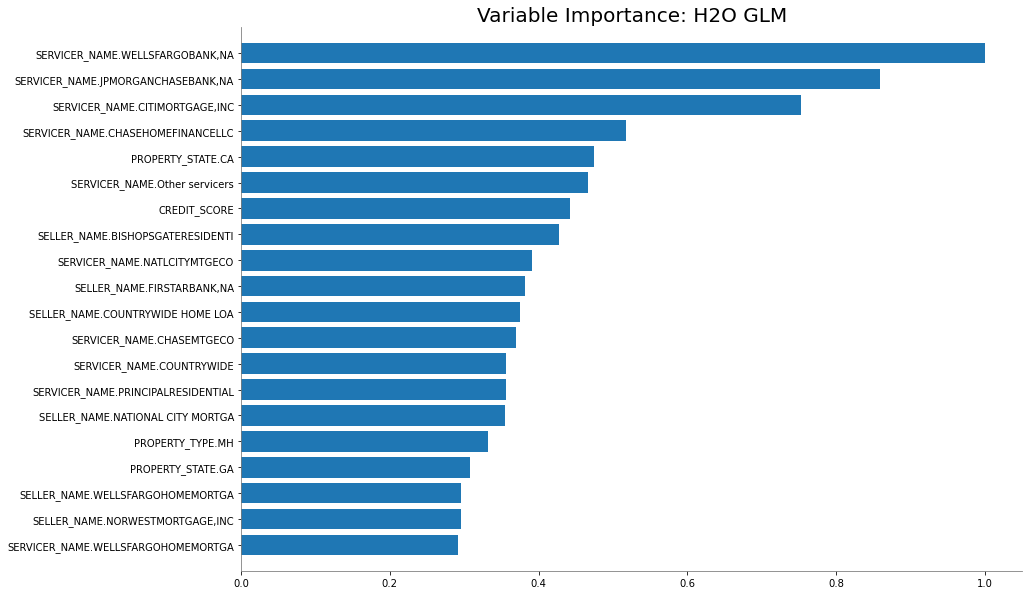

In [17]:
#> 変数重要度プロットとして表示
glm.varimp_plot(20)

In [ ]:
AUC: 0.8503678632126709
AUC: 0.8450514045844325

In [50]:
#> validデータでの結果の取得
default_glm_perf = glm.model_performance(valid)

In [53]:
print('AUC on train data: ', glm.auc())
print('AUC on valid data: ', default_glm_perf.auc())

AUC on train data:  0.8503678632126709
AUC on valid data:  0.8450514045844325


In [18]:
# testデータへの予測の実施
glm_predict_test = glm.predict(test)

glm prediction progress: |████████████████████████████████████████████████| 100%


In [19]:
glm_predict_test

predict,FALSE,TRUE
FALSE,0.997271,0.00272888
FALSE,0.997216,0.00278368
FALSE,0.994288,0.00571223
FALSE,0.983743,0.0162569
FALSE,0.981717,0.0182828
FALSE,0.984756,0.0152437
TRUE,0.756884,0.243116
FALSE,0.980478,0.0195224
FALSE,0.990613,0.00938657
FALSE,0.987829,0.0121712


***

<a id='BuildRandomForest'></a>
### Build a Random Forest

[**Distributed Random Forest (DRF) - ドキュメント**](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/drf.html)  
[**H2ORandomForestEstimato - APIドキュメント**](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2orandomforestestimator)

In [20]:
rf = H2ORandomForestEstimator(seed=42, model_id='default_rf')
%time rf.train(x=x, y=y, training_frame=train, validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%
Wall time: 24.5 s


In [21]:
rf

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  default_rf


Model Summary: 


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,50.0,50.0,7598177.0,20.0,20.0,20.0,9881.0,11724.0,10834.34




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.03217049865504144
RMSE: 0.17936136332845334
LogLoss: 0.18808040483623295
Mean Per-Class Error: 0.26898748876223844
AUC: 0.8032997647765378
AUCPR: 0.1987335412957797
Gini: 0.6065995295530755

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1720264946703493: 


,FALSE,TRUE,Error,Rate
FALSE,322449.0,15158.0,0.0449,(15158.0/337607.0)
TRUE,8465.0,4196.0,0.6686,(8465.0/12661.0)
Total,330914.0,19354.0,0.0674,(23623.0/350268.0)



Maximum Metrics: Maximum metrics at their respective thresholds


metric,threshold,value,idx
max f1,0.1720265,0.2621271,193.0
max f2,0.0860089,0.3456159,267.0
max f0point5,0.2857323,0.2724206,128.0
max accuracy,0.5707684,0.9642731,41.0
max precision,0.9981481,1.0,0.0
max recall,0.0000040,1.0,399.0
max specificity,0.9981481,1.0,0.0
max absolute_mcc,0.1538560,0.2345485,206.0
max min_per_class_accuracy,0.0377419,0.7279046,328.0
max mean_per_class_accuracy,0.0137389,0.7310125,361.0



Gains/Lift Table: Avg response rate:  3.61 %, avg score:  3.75 %


group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
1,0.0100009,0.3558069,10.8117443,10.8117443,0.3908079,0.4681848,0.3908079,0.4681848,0.1081273,0.1081273,981.1744266,981.1744266,0.1018064
2,0.0200018,0.2766559,6.5470679,8.6794061,0.2366543,0.3112732,0.3137311,0.3897290,0.0654767,0.1736040,554.7067930,767.9406098,0.1593626
3,0.0300027,0.2321429,5.1728944,7.5105689,0.1869826,0.2526005,0.2714816,0.3440195,0.0517337,0.2253377,417.2894444,651.0568880,0.2026604
4,0.0400008,0.2026765,4.4080906,6.7351154,0.1593375,0.2170466,0.2434516,0.3122831,0.0440723,0.2694100,340.8090589,573.5115381,0.2380125
5,0.0500017,0.1809948,4.0119548,6.1904522,0.1450186,0.1917488,0.2237638,0.2881748,0.0401232,0.3095332,301.1954775,519.0452163,0.2692645
6,0.1002175,0.1176471,2.9444023,4.5639595,0.1064302,0.1446111,0.1649717,0.2162396,0.1478556,0.4573888,194.4402307,356.3959529,0.3705660
7,0.1500023,0.0815302,2.0862269,3.7416169,0.0754100,0.0981565,0.1352468,0.1770486,0.1038623,0.5612511,108.6226863,274.1616935,0.4266715
8,0.2025592,0.0625,1.4982953,3.1595548,0.0541583,0.0703209,0.1142072,0.1493566,0.0787458,0.6399968,49.8295290,215.9554805,0.4538425
9,0.3000017,0.0305246,1.0593977,2.4774100,0.0382936,0.0494365,0.0895500,0.1169019,0.1032304,0.7432272,5.9397707,147.7409965,0.4598474
10,0.3999994,0.0083209,0.9067421,2.0847514,0.0327757,0.0162761,0.0753567,0.0917460,0.0906721,0.8338994,-9.3257862,108.4751416,0.4501721




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.03071157490750514
RMSE: 0.1752471823097454
LogLoss: 0.13267563440956415
Mean Per-Class Error: 0.24881538981472118
AUC: 0.826374425170771
AUCPR: 0.2236621278161126
Gini: 0.652748850341542

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18667329417807715: 


,FALSE,TRUE,Error,Rate
FALSE,70114.0,2199.0,0.0304,(2199.0/72313.0)
TRUE,1858.0,800.0,0.699,(1858.0/2658.0)
Total,71972.0,2999.0,0.0541,(4057.0/74971.0)



Maximum Metrics: Maximum metrics at their respective thresholds


metric,threshold,value,idx
max f1,0.1866733,0.2828354,166.0
max f2,0.0932270,0.3650134,247.0
max f0point5,0.2869302,0.3071325,112.0
max accuracy,0.5079471,0.9651332,43.0
max precision,0.9966667,1.0,0.0
max recall,0.0000204,1.0,399.0
max specificity,0.9966667,1.0,0.0
max absolute_mcc,0.1914849,0.2554874,163.0
max min_per_class_accuracy,0.0415546,0.7490594,313.0
max mean_per_class_accuracy,0.0427906,0.7511846,311.0



Gains/Lift Table: Avg response rate:  3.55 %, avg score:  3.75 %


group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
1,0.0100039,0.3250724,12.3729416,12.3729416,0.4386667,0.4390377,0.4386667,0.4390377,0.1237773,0.1237773,1137.2941560,1137.2941560,0.1179554
2,0.0200077,0.2485675,7.0702523,9.7215969,0.2506667,0.2820769,0.3446667,0.3605573,0.0707299,0.1945071,607.0252320,872.1596940,0.1809135
3,0.0300116,0.2109016,5.7163742,8.3865227,0.2026667,0.2280560,0.2973333,0.3163902,0.0571859,0.2516930,471.6374216,738.6522699,0.2298297
4,0.0400021,0.1859585,4.9331896,7.5240530,0.1748999,0.1978494,0.2667556,0.2867846,0.0492852,0.3009782,393.3189575,652.4053039,0.2705687
5,0.0500060,0.1662264,3.7231648,6.7636726,0.132,0.1757035,0.2397973,0.2645625,0.0372460,0.3382242,272.3164786,576.3672620,0.2988122
6,0.1000120,0.1077842,3.0696089,4.9166408,0.1088290,0.1330630,0.1743132,0.1988127,0.1534989,0.4917231,206.9608931,391.6640776,0.4061092
7,0.1500047,0.0778495,2.0168497,3.9502157,0.0715048,0.0915786,0.1400498,0.1630744,0.1008277,0.5925508,101.6849719,295.0215657,0.4588127
8,0.2000107,0.0591888,1.4971867,3.3369175,0.0530808,0.0668143,0.1183061,0.1390077,0.0748683,0.6674191,49.7186709,233.6917523,0.4845889
9,0.3000093,0.0337297,1.0872982,2.5870777,0.0385488,0.0449705,0.0917215,0.1076634,0.1087284,0.7761475,8.7298175,158.7077746,0.4936395
10,0.4000080,0.0212588,0.7148327,2.1190321,0.0253435,0.0258708,0.0751275,0.0872159,0.0714823,0.8476298,-28.5167290,111.9032095,0.4640750




Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2020-09-10 09:03:33,0.016 sec,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2020-09-10 09:03:34,0.495 sec,1.0,0.2384855,1.7726475,0.5796301,0.0685664,4.1995080,0.0742338,0.2353475,1.7255748,0.5852848,0.0717549,4.5826040,0.0700804
,2020-09-10 09:03:34,0.975 sec,2.0,0.2308665,1.5287933,0.5970442,0.0756005,4.3809510,0.0792059,0.2058508,0.8100131,0.6415982,0.0990679,6.5061364,0.0947967
,2020-09-10 09:03:35,1.469 sec,3.0,0.2251617,1.3550030,0.6100472,0.0812394,4.6883043,0.0783481,0.1961767,0.6012313,0.6863447,0.1208925,8.1549908,0.0929159
,2020-09-10 09:03:35,2.025 sec,4.0,0.2205815,1.2210591,0.6142966,0.0821857,4.5864444,0.0827593,0.1914640,0.5258920,0.6978533,0.1311060,7.2976895,0.0526870
,2020-09-10 09:03:36,2.589 sec,5.0,0.2152217,1.0744318,0.6225788,0.0869088,5.0214076,0.0872593,0.1877438,0.4335955,0.7191083,0.1456852,9.1386772,0.0600499
,2020-09-10 09:03:37,3.180 sec,6.0,0.2109699,0.9592704,0.6353108,0.0915097,5.7943207,0.0940396,0.1859410,0.3944023,0.7287055,0.1503423,9.3894121,0.0689467
,2020-09-10 09:03:37,3.868 sec,7.0,0.2071891,0.8678764,0.6455324,0.0970186,6.4838875,0.0957723,0.1842725,0.3554339,0.7416020,0.1587043,9.2344136,0.0725080
,2020-09-10 09:03:42,8.172 sec,17.0,0.1883114,0.4163510,0.7289472,0.1421317,8.4967522,0.0717921,0.1784028,0.1952250,0.7941311,0.1935770,10.9669287,0.0625842
,2020-09-10 09:03:47,13.847 sec,30.0,0.1822860,0.2647162,0.7737348,0.1769386,10.0693747,0.0689617,0.1762714,0.1503146,0.8140037,0.2137115,11.7712180,0.0624908



Variable Importances: 


variable,relative_importance,scaled_importance,percentage
PROPERTY_STATE,42236.5468750,1.0,0.1344749
CREDIT_SCORE,38299.6132812,0.9067885,0.1219403
SELLER_NAME,31417.1855469,0.7438389,0.1000277
SERVICER_NAME,25920.6230469,0.6137013,0.0825274
ORIGINAL_DEBT_TO_INCOME_RATIO,23534.9882812,0.5572186,0.0749319
---,---,---,---
CHANNEL,4179.7534180,0.0989606,0.0133077
NUMBER_OF_BORROWERS,4068.8198242,0.0963341,0.0129545
OCCUPANCY_STATUS,2614.1867676,0.0618940,0.0083232
NUMBER_OF_UNITS,1214.7104492,0.0287597,0.0038675


GLMとの相違
- Scoring History:　➡　木の数が増えるに従っての、各精度指標の変化  
- Variable Importances:　➡　レポートの最終行に、変数重要度が表示
  
[ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/drf.html#interpreting-a-drf-model)

In [22]:
#> 推定したモデルの設定やハイパーパラメータの確認
rf.actual_params

{'model_id': 'default_rf',
 'training_frame': 'py_4_sid_a0e5',
 'validation_frame': 'py_5_sid_a0e5',
 'nfolds': 0,
 'keep_cross_validation_models': True,
 'keep_cross_validation_predictions': False,
 'keep_cross_validation_fold_assignment': False,
 'score_each_iteration': False,
 'score_tree_interval': 0,
 'fold_assignment': None,
 'fold_column': None,
 'response_column': 'DELINQUENT',
 'ignored_columns': ['PREPAYMENT_PENALTY_MORTGAGE_FLAG',
  'PRODUCT_TYPE',
  'PREPAID',
  'LOAN_SEQUENCE_NUMBER'],
 'ignore_const_cols': True,
 'offset_column': None,
 'weights_column': None,
 'balance_classes': False,
 'class_sampling_factors': None,
 'max_after_balance_size': 5.0,
 'max_confusion_matrix_size': 20,
 'max_hit_ratio_k': 0,
 'ntrees': 50,
 'max_depth': 20,
 'min_rows': 1.0,
 'nbins': 20,
 'nbins_top_level': 1024,
 'nbins_cats': 1024,
 'r2_stopping': 1.7976931348623157e+308,
 'stopping_rounds': 0,
 'stopping_metric': None,
 'stopping_tolerance': 0.001,
 'max_runtime_secs': 0.0,
 'seed': 42,

- 各内容に関しての[ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/drf.html#defining-a-drf-model)、[APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2orandomforestestimator)

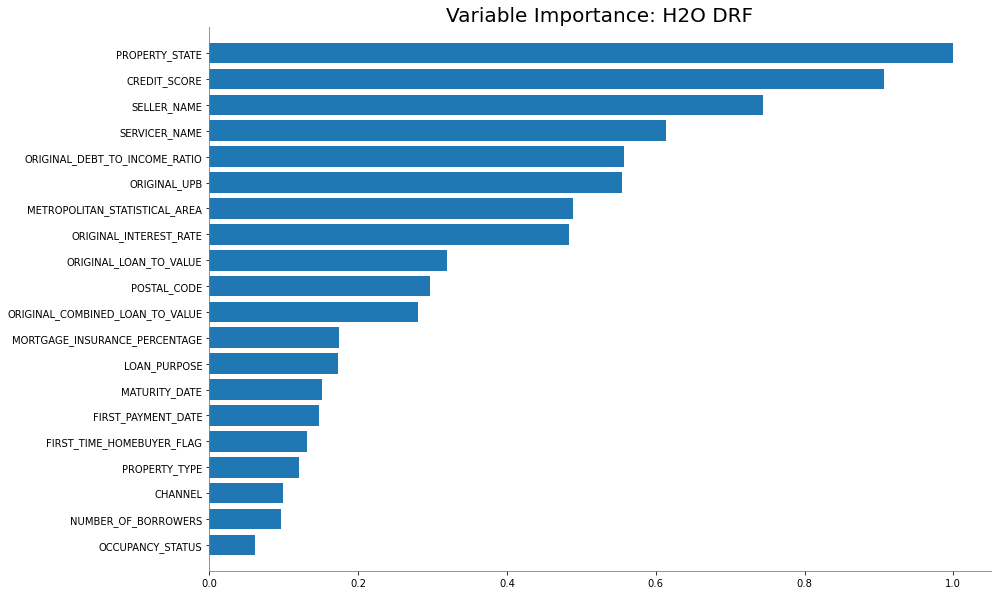

In [23]:
#> 変数重要度の表示
rf.varimp_plot(20)

- 値自体を取得する場合 `rf.varimp()`
- カテゴリ変数もone-hot encodingされた形でなく、元の変数として値がまとめられている

In [24]:
# testデータへの予測の実施
rf_predict_test = rf.predict(test)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [25]:
rf_predict_test

predict,FALSE,TRUE
FALSE,0.997706,0.00229439
FALSE,0.999815,0.000185186
FALSE,0.999842,0.000157895
FALSE,0.995645,0.00435477
FALSE,0.997735,0.00226481
FALSE,0.97729,0.0227096
FALSE,0.829447,0.170553
FALSE,0.988974,0.0110256
FALSE,0.996457,0.00354298
FALSE,0.998178,0.00182216


その他DRF特有の仕様に関する[FAQ](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/drf.html#faq)

***

<a id='BuildGBM'></a>
### Build a GBM

[**Gradient Boosting Machine (GBM) - ドキュメント**](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm.html)  
[**H2OGradientBoostingEstimator - APIドキュメント**](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2ogradientboostingestimator)

In [26]:
gbm= H2OGradientBoostingEstimator(seed=42, model_id='default_gbm')
%time gbm.train(x=x, y=y, training_frame=train, validation_frame = valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Wall time: 11.1 s


In [27]:
gbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  default_gbm


Model Summary: 


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,50.0,50.0,28337.0,5.0,5.0,5.0,25.0,32.0,30.96




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.029506421363469558
RMSE: 0.17177433266780448
LogLoss: 0.11505127038888413
Mean Per-Class Error: 0.2023981537369366
AUC: 0.8781534619393979
AUCPR: 0.2949994365454658
Gini: 0.7563069238787958

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1559417963582079: 


,FALSE,TRUE,Error,Rate
FALSE,326775.0,10832.0,0.0321,(10832.0/337607.0)
TRUE,7791.0,4870.0,0.6154,(7791.0/12661.0)
Total,334566.0,15702.0,0.0532,(18623.0/350268.0)



Maximum Metrics: Maximum metrics at their respective thresholds


metric,threshold,value,idx
max f1,0.1559418,0.3434051,195.0
max f2,0.0709855,0.4281688,269.0
max f0point5,0.2699511,0.3651525,133.0
max accuracy,0.4509460,0.9650353,71.0
max precision,0.8967277,1.0,0.0
max recall,0.0031005,1.0,399.0
max specificity,0.8967277,1.0,0.0
max absolute_mcc,0.1459562,0.3184316,202.0
max min_per_class_accuracy,0.0398786,0.7959087,310.0
max mean_per_class_accuracy,0.0391918,0.7976018,311.0



Gains/Lift Table: Avg response rate:  3.61 %, avg score:  3.62 %


group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
1,0.0100009,0.3459722,14.2866657,14.2866657,0.5164145,0.4798980,0.5164145,0.4798980,0.1428797,0.1428797,1328.6665724,1328.6665724,0.1378620
2,0.0200018,0.2476403,9.0111031,11.6488844,0.3257208,0.2904899,0.4210677,0.3851940,0.0901193,0.2329990,801.1103146,1064.8884435,0.2209850
3,0.0300027,0.1979966,7.1393841,10.1457177,0.2580645,0.2205816,0.3667333,0.3303232,0.0714004,0.3043993,613.9384088,914.5717653,0.2846871
4,0.0400008,0.1667858,5.4824639,8.9801538,0.1981725,0.1812546,0.3246021,0.2930640,0.0548140,0.3592133,448.2463923,798.0153841,0.3311837
5,0.0500017,0.1447485,4.8806851,8.1602133,0.1764202,0.1550752,0.2949640,0.2654647,0.0488113,0.4080246,388.0685140,716.0213287,0.3714496
6,0.1000006,0.0858736,3.4058119,5.7830805,0.1231085,0.1105670,0.2090387,0.1880180,0.1702867,0.5783113,240.5811932,478.3080477,0.4962485
7,0.1500023,0.0598800,2.2509299,4.6056745,0.0813635,0.0715717,0.1664795,0.1492018,0.1125504,0.6908617,125.0929914,360.5674547,0.5611428
8,0.2000011,0.0446090,1.5259807,3.8357731,0.0551590,0.0516615,0.1386502,0.1248175,0.0762973,0.7671590,52.5980671,283.5773059,0.5884275
9,0.3000017,0.0277932,0.9920171,2.8878544,0.0358581,0.0351535,0.1043861,0.0949295,0.0992023,0.8663613,-0.7982917,188.7854400,0.5875993
10,0.3999994,0.0190800,0.5378845,2.3003745,0.0194427,0.0230117,0.0831507,0.0769504,0.0537872,0.9201485,-46.2115509,130.0374502,0.5396558




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.030145356735784876
RMSE: 0.17362418246253855
LogLoss: 0.11952062413571642
Mean Per-Class Error: 0.2236150019056964
AUC: 0.8542077452216156
AUCPR: 0.2377484046519532
Gini: 0.7084154904432312

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16724513523079657: 


,FALSE,TRUE,Error,Rate
FALSE,70224.0,2089.0,0.0289,(2089.0/72313.0)
TRUE,1822.0,836.0,0.6855,(1822.0/2658.0)
Total,72046.0,2925.0,0.0522,(3911.0/74971.0)



Maximum Metrics: Maximum metrics at their respective thresholds


metric,threshold,value,idx
max f1,0.1672451,0.2994806,177.0
max f2,0.0708709,0.3926062,260.0
max f0point5,0.2516964,0.3212324,130.0
max accuracy,0.5926783,0.9649464,29.0
max precision,0.8954254,1.0,0.0
max recall,0.0032871,1.0,398.0
max specificity,0.8954254,1.0,0.0
max absolute_mcc,0.1004416,0.2798477,229.0
max min_per_class_accuracy,0.0355824,0.7733049,311.0
max mean_per_class_accuracy,0.0313174,0.7763850,318.0



Gains/Lift Table: Avg response rate:  3.55 %, avg score:  3.60 %


group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
1,0.0100039,0.3442365,13.0122729,13.0122729,0.4613333,0.4734278,0.4613333,0.4734278,0.1301731,0.1301731,1201.2272887,1201.2272887,0.1245862
2,0.0200077,0.2430684,7.7847991,10.3985360,0.276,0.2876289,0.3686667,0.3805284,0.0778781,0.2080512,678.4799097,939.8535992,0.1949553
3,0.0300116,0.1950263,6.0548437,8.9506386,0.2146667,0.2173147,0.3173333,0.3261238,0.0605719,0.2686230,505.4843742,795.0638575,0.2473820
4,0.0400021,0.1634818,4.9331896,7.9472810,0.1748999,0.1784159,0.2817606,0.2892338,0.0492852,0.3179082,393.3189575,694.7281022,0.2881210
5,0.0500060,0.1419665,3.7231648,7.1022324,0.132,0.1525111,0.2518005,0.2618820,0.0372460,0.3551543,272.3164786,610.2232429,0.3163645
6,0.1000120,0.0858650,3.4683572,5.2852948,0.1229661,0.1095518,0.1873833,0.1857169,0.1734387,0.5285929,246.8357150,428.5294789,0.4443342
7,0.1500047,0.0602794,2.1974631,4.2562006,0.0779082,0.0716925,0.1508981,0.1477155,0.1098570,0.6384500,119.7463127,325.6200616,0.5063990
8,0.2000107,0.0444454,1.6175635,3.5964974,0.0573486,0.0517582,0.1275092,0.1237246,0.0808879,0.7193378,61.7563530,259.6497353,0.5384160
9,0.3000093,0.0277766,1.0684868,2.7538646,0.0378818,0.0351851,0.0976347,0.0942127,0.1068473,0.8261851,6.8486788,175.3864630,0.5455163
10,0.4000080,0.0191216,0.6395872,2.2253129,0.0226757,0.0230183,0.0788956,0.0764147,0.0639579,0.8901430,-36.0412838,122.5312888,0.5081508




Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2020-09-10 09:03:59,0.019 sec,0.0,0.1866548,0.1554983,0.5,0.0361466,1.0,0.9638534,0.1849249,0.1532232,0.5,0.0354537,1.0,0.9645463
,2020-09-10 09:04:00,0.305 sec,1.0,0.1847652,0.1477929,0.8133172,0.1791287,8.5557195,0.0757420,0.1830987,0.1458902,0.8020845,0.1692429,8.7207467,0.0566619
,2020-09-10 09:04:00,0.554 sec,2.0,0.1834594,0.1435424,0.8264729,0.1877201,8.7915814,0.0757420,0.1818922,0.1420110,0.8128561,0.1737144,8.8189294,0.0711342
,2020-09-10 09:04:00,0.812 sec,3.0,0.1823413,0.1402099,0.8350797,0.1985932,10.4877832,0.0577215,0.1808611,0.1389537,0.8212643,0.1837731,10.0262783,0.0606901
,2020-09-10 09:04:01,1.220 sec,4.0,0.1813681,0.1374933,0.8402067,0.2071437,10.7655051,0.0664091,0.1799752,0.1364744,0.8269107,0.1907322,10.4900612,0.0618372
,2020-09-10 09:04:01,1.645 sec,5.0,0.1805827,0.1354412,0.8416326,0.2106199,11.0140346,0.0650216,0.1792787,0.1346241,0.8287832,0.1931933,10.3521265,0.0621440
,2020-09-10 09:04:01,2.035 sec,6.0,0.1798666,0.1335823,0.8436058,0.2146061,11.1196721,0.0683305,0.1786593,0.1330045,0.8300828,0.1966698,10.5771727,0.0680530
,2020-09-10 09:04:02,2.409 sec,7.0,0.1792049,0.1318952,0.8465836,0.2200640,11.3540269,0.0662978,0.1780587,0.1314658,0.8325132,0.2022745,10.6805939,0.0593963
,2020-09-10 09:04:02,2.807 sec,8.0,0.1786655,0.1305453,0.8480632,0.2234868,11.5350259,0.0626320,0.1776175,0.1303217,0.8335691,0.2038977,10.9438480,0.0741887
,2020-09-10 09:04:03,3.199 sec,9.0,0.1781678,0.1293649,0.8491173,0.2265428,11.6381009,0.0651358,0.1772225,0.1293543,0.8339804,0.2055104,11.1022806,0.0715343



Variable Importances: 


variable,relative_importance,scaled_importance,percentage
CREDIT_SCORE,2309.6586914,1.0,0.2949230
SERVICER_NAME,1683.9562988,0.7290931,0.2150263
PROPERTY_STATE,1255.2222900,0.5434666,0.1602808
SELLER_NAME,997.2852173,0.4317890,0.1273445
NUMBER_OF_BORROWERS,316.2933960,0.1369438,0.0403879
---,---,---,---
METROPOLITAN_STATISTICAL_AREA,11.2933874,0.0048896,0.0014421
FIRST_TIME_HOMEBUYER_FLAG,1.4684173,0.0006358,0.0001875
NUMBER_OF_UNITS,0.0,0.0,0.0
POSTAL_CODE,0.0,0.0,0.0


Random Forestと同様の内容   
[ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm.html#interpreting-a-gbm-model)

In [28]:
#> 推定したモデルの設定やハイパーパラメータの確認
gbm.actual_params

{'model_id': 'default_gbm',
 'training_frame': 'py_4_sid_a0e5',
 'validation_frame': 'py_5_sid_a0e5',
 'nfolds': 0,
 'keep_cross_validation_models': True,
 'keep_cross_validation_predictions': False,
 'keep_cross_validation_fold_assignment': False,
 'score_each_iteration': False,
 'score_tree_interval': 0,
 'fold_assignment': None,
 'fold_column': None,
 'response_column': 'DELINQUENT',
 'ignored_columns': ['PREPAYMENT_PENALTY_MORTGAGE_FLAG',
  'PRODUCT_TYPE',
  'PREPAID',
  'LOAN_SEQUENCE_NUMBER'],
 'ignore_const_cols': True,
 'offset_column': None,
 'weights_column': None,
 'balance_classes': False,
 'class_sampling_factors': None,
 'max_after_balance_size': 5.0,
 'max_confusion_matrix_size': 20,
 'max_hit_ratio_k': 0,
 'ntrees': 50,
 'max_depth': 5,
 'min_rows': 10.0,
 'nbins': 20,
 'nbins_top_level': 1024,
 'nbins_cats': 1024,
 'r2_stopping': 1.7976931348623157e+308,
 'stopping_rounds': 0,
 'stopping_metric': None,
 'stopping_tolerance': 0.001,
 'max_runtime_secs': 0.0,
 'seed': 42

- 各内容に関しての[ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm.html#defining-a-gbm-model)、[APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2ogradientboostingestimator)

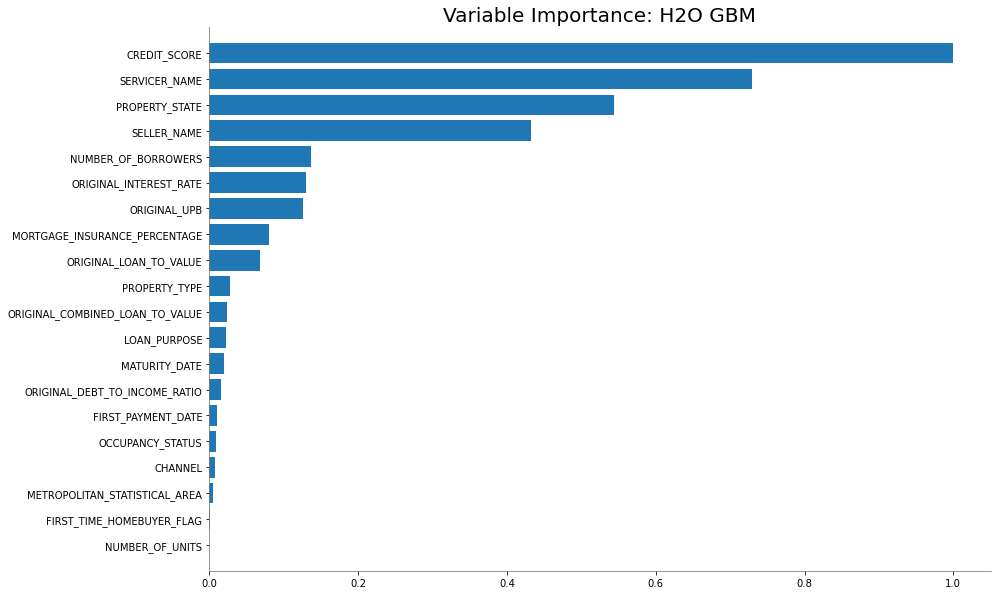

In [29]:
#> 変数重要度の表示
gbm.varimp_plot(20)

- 値自体を取得する場合 `gbm.varimp()`

In [30]:
# testデータへの予測の実施
gbm_predict_test = gbm.predict(test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [31]:
gbm_predict_test

predict,FALSE,TRUE
FALSE,0.994142,0.00585837
FALSE,0.98943,0.0105703
FALSE,0.992075,0.00792452
FALSE,0.9856,0.0144002
FALSE,0.982951,0.0170495
FALSE,0.986702,0.0132977
TRUE,0.666894,0.333106
FALSE,0.990123,0.00987703
FALSE,0.987575,0.0124254
FALSE,0.986317,0.0136831


その他GBM特有の仕様に関する[FAQ](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm.html#faq)

***

<a id='TuneGLMGridSearch'></a>
### Tune the GLM with H2O GridSearch

[**Gred Search - ドキュメント**](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html#grid-hyperparameter-search)  
[**H2OGridSearch - APIドキュメント**](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2ogridsearch)

In [32]:
glm_grid = h2o.grid.H2OGridSearch (
    # モデルの指定
    H2OGeneralizedLinearEstimator(family="binomial", lambda_search=True),
    
    # 探索するハイパーパラメーターとその範囲
    hyper_params = {
        "alpha": [x*0.01 for x in range(0, 100)],
        "lambda": [x*1e-8 for x in range(0, 10000)],
        "missing_values_handling" : ["Skip", "MeanImputation"]
        },

    # 結果のオブジェクトに対するID(オプション)
    grid_id = "glm_random_grid",
    
    # 探索の方針
    search_criteria = {
        "strategy":"RandomDiscrete",   # ランダムサーチ
        "max_models":200,
        "max_runtime_secs":300,
        "seed":42
        }
)

In [33]:
len([x*0.01 for x in range(0, 100)]) * len([x*1e-8 for x in range(0, 10000)]) * len(["Skip", "MeanImputation"])

2000000

- 2,000,000のハイパーパラメータの組み合わせ

[search_criteria](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.grid.H2OGridSearch)
- ランダムサーチ("RandomDiscrete")を、ストップ基準（最大モデル数("max_models":200)、最大探索時間("max_runtime_secs":300)）を設定して実施（2,000,000のハイパーパラメータの組み合わの中からランダムに探索）

各ハイパーパラメータに関して
- alpha - [ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/alpha.html)、[APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.glm.H2OGeneralizedLinearEstimator.alpha)
- lambda - [ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/lambda.html)、[APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.glm.H2OGeneralizedLinearEstimator.Lambda)
- missing_values_handling - [ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/missing_values_handling.html)、[APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.glm.H2OGeneralizedLinearEstimator.missing_values_handling)  

[GLMがサポートするハイパーパラメーター一覧](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html#glm-hyperparameters)

In [38]:
%time glm_grid.train(x=x, y=y, training_frame=train, validation_frame=valid)

glm Grid Build progress: |████████████████████████████████████████████████| 100%
Wall time: 4min 55s


In [39]:
#> 探索結果の表示
glm_grid


Hyper-Parameter Search Summary: ordered by increasing logloss


,alpha,lambda,missing_values_handling,model_ids,logloss
,[0.06],[3.04E-6],Skip,glm_random_grid_model_297,0.1194880
,[0.06],[3.04E-6],Skip,glm_random_grid_model_497,0.1194880
,[0.06],[3.04E-6],Skip,glm_random_grid_model_97,0.1194880
,[0.0],[6.01E-6],Skip,glm_random_grid_model_280,0.1194908
,[0.0],[6.01E-6],Skip,glm_random_grid_model_480,0.1194908
---,---,---,---,---,---
,[0.9],[9.641000000000001E-5],MeanImputation,glm_random_grid_model_210,0.1232021
,[0.9],[9.641000000000001E-5],MeanImputation,glm_random_grid_model_410,0.1232021
,[0.97],[9.232E-5],MeanImputation,glm_random_grid_model_195,0.1232089
,[0.97],[9.232E-5],MeanImputation,glm_random_grid_model_395,0.1232089


- デフォルトではlog lossの小さい順で結果が返る

In [41]:
#> 探索結果の表示（AUCによる評価）
glm_grid.get_grid(sort_by='auc', decreasing=True)


Hyper-Parameter Search Summary: ordered by decreasing auc


,alpha,lambda,missing_values_handling,model_ids,auc
,[0.0],[6.01E-6],Skip,glm_random_grid_model_280,0.8533922
,[0.0],[6.01E-6],Skip,glm_random_grid_model_480,0.8533922
,[0.0],[6.01E-6],Skip,glm_random_grid_model_80,0.8533922
,[0.52],[7.690000000000001E-6],Skip,glm_random_grid_model_163,0.8533826
,[0.52],[7.690000000000001E-6],Skip,glm_random_grid_model_363,0.8533826
---,---,---,---,---,---
,[0.9],[9.641000000000001E-5],MeanImputation,glm_random_grid_model_210,0.8438630
,[0.9],[9.641000000000001E-5],MeanImputation,glm_random_grid_model_410,0.8438630
,[0.97],[9.232E-5],MeanImputation,glm_random_grid_model_195,0.8438183
,[0.97],[9.232E-5],MeanImputation,glm_random_grid_model_395,0.8438183


In [62]:
#> log loss基準で最適なモデルを取得
tuned_glm = glm_grid.models[0]
tuned_glm

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  glm_random_grid_model_297


GLM Model: summary


,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,binomial,logit,"Elastic Net (alpha = 0.06, lambda = 3.04E-6 )","nlambda = 100, lambda.max = 0.5536, lambda.min = 3.04E-6, lambda.1se = -1.0",161,160,5,py_4_sid_a0e5




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.030957743888348536
RMSE: 0.17594812840251678
LogLoss: 0.12081166947879722
Null degrees of freedom: 259734
Residual degrees of freedom: 259574
Null deviance: 80266.83939893392
Residual deviance: 62758.0379441508
AIC: 63080.0379441508
AUC: 0.8576544023458436
AUCPR: 0.2158253225750789
Gini: 0.7153088046916871

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1428755256395368: 


,FALSE,TRUE,Error,Rate
FALSE,240394.0,10030.0,0.0401,(10030.0/250424.0)
TRUE,5921.0,3390.0,0.6359,(5921.0/9311.0)
Total,246315.0,13420.0,0.0614,(15951.0/259735.0)



Maximum Metrics: Maximum metrics at their respective thresholds


metric,threshold,value,idx
max f1,0.1428755,0.2982711,205.0
max f2,0.0688517,0.3955148,269.0
max f0point5,0.2118892,0.2939841,162.0
max accuracy,0.9880233,0.9641481,0.0
max precision,0.6068786,0.4346734,41.0
max recall,0.0005914,1.0,399.0
max specificity,0.9880233,0.9999960,0.0
max absolute_mcc,0.1030280,0.2766125,236.0
max min_per_class_accuracy,0.0389060,0.7781119,310.0
max mean_per_class_accuracy,0.0342773,0.7812644,318.0



Gains/Lift Table: Avg response rate:  3.58 %, avg score:  3.58 %


group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
1,0.0100025,0.3377061,10.7480352,10.7480352,0.3852964,0.4734985,0.3852964,0.4734985,0.1075072,0.1075072,974.8035199,974.8035199,0.1011301
2,0.0200012,0.2462096,8.1312643,9.4399016,0.2914902,0.2855821,0.3384023,0.3795584,0.0813017,0.1888089,713.1264328,843.9901618,0.1750842
3,0.0300037,0.1996189,6.3779550,8.4191218,0.2286374,0.2210016,0.3018093,0.3266993,0.0637955,0.2526044,537.7954953,741.9121760,0.2308773
4,0.0400023,0.1673755,5.3384919,7.6491125,0.1913747,0.1825462,0.2742060,0.2906680,0.0533777,0.3059822,433.8491903,664.9112545,0.2758692
5,0.0500010,0.1452779,4.9088346,7.1011414,0.1759723,0.1558236,0.2545623,0.2637033,0.0490817,0.3550639,390.8834607,610.1141358,0.3164055
6,0.1000019,0.0875781,3.4281372,5.2646393,0.1228921,0.1118433,0.1887272,0.1877733,0.1714102,0.5264741,242.8137208,426.4639283,0.4423288
7,0.1500029,0.0614915,2.3734910,4.3009232,0.0850851,0.0732029,0.1541798,0.1495831,0.1186768,0.6451509,137.3490986,330.0923184,0.5135581
8,0.2,0.0465852,1.6626457,3.6413919,0.0596026,0.0534669,0.1305369,0.1255555,0.0831275,0.7282784,66.2645692,264.1391902,0.5479203
9,0.3000019,0.0294835,1.0922354,2.7916622,0.0391545,0.0370672,0.1000757,0.0960590,0.1092256,0.8375040,9.2235445,179.1662178,0.5574869
10,0.4,0.0198669,0.6143390,2.2473419,0.0220229,0.0242810,0.0805629,0.0781148,0.0614327,0.8989367,-38.5661034,124.7341854,0.5174877




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.030453937046944893
RMSE: 0.17451056428464407
LogLoss: 0.11948800283864972
Null degrees of freedom: 55596
Residual degrees of freedom: 55436
Null deviance: 16753.086396281822
Residual deviance: 13286.348987640817
AIC: 13608.348987640817
AUC: 0.8533806692304582
AUCPR: 0.19846221023218455
Gini: 0.7067613384609164

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1257504779910922: 


,FALSE,TRUE,Error,Rate
FALSE,51023.0,2646.0,0.0493,(2646.0/53669.0)
TRUE,1173.0,755.0,0.6084,(1173.0/1928.0)
Total,52196.0,3401.0,0.0687,(3819.0/55597.0)



Maximum Metrics: Maximum metrics at their respective thresholds


metric,threshold,value,idx
max f1,0.1257505,0.2833552,202.0
max f2,0.0727192,0.3846154,256.0
max f0point5,0.2312559,0.2856529,136.0
max accuracy,0.9807510,0.9653039,0.0
max precision,0.3770918,0.3761682,83.0
max recall,0.0009540,1.0,397.0
max specificity,0.9807510,0.9999814,0.0
max absolute_mcc,0.0840623,0.2664969,244.0
max min_per_class_accuracy,0.0380796,0.7738589,306.0
max mean_per_class_accuracy,0.0359798,0.7762970,310.0



Gains/Lift Table: Avg response rate:  3.47 %, avg score:  3.58 %


group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
1,0.0100005,0.3359759,10.5803420,10.5803420,0.3669065,0.4851982,0.3669065,0.4851982,0.1058091,0.1058091,958.0341951,958.0341951,0.0992504
2,0.0200011,0.2459761,8.1945786,9.3874603,0.2841727,0.2854031,0.3255396,0.3853006,0.0819502,0.1877593,719.4578570,838.7460260,0.1737848
3,0.0300016,0.1957713,6.2237306,8.3328837,0.2158273,0.2189261,0.2889688,0.3298425,0.0622407,0.25,522.3730559,733.2883693,0.2279016
4,0.0400022,0.1652324,4.9789844,7.4944089,0.1726619,0.1791379,0.2598921,0.2921663,0.0497925,0.2997925,397.8984447,649.4408882,0.2691231
5,0.0500027,0.1436371,4.2528825,6.8461036,0.1474820,0.1534325,0.2374101,0.2644196,0.0425311,0.3423237,325.2882549,584.6103615,0.3028223
6,0.1000054,0.0874093,3.4437976,5.1449506,0.1194245,0.1106821,0.1784173,0.1875508,0.1721992,0.5145228,244.3797576,414.4950596,0.4294085
7,0.1500081,0.0616265,2.4894922,4.2597978,0.0863309,0.0730471,0.1477218,0.1493829,0.1244813,0.6390041,148.9492224,325.9797805,0.5065627
8,0.2000108,0.0468595,1.4522038,3.5578993,0.0503597,0.0536723,0.1233813,0.1254552,0.0726141,0.7116183,45.2203797,255.7899303,0.5299864
9,0.2999982,0.0294529,1.1412225,2.7524370,0.0395755,0.0372157,0.0954494,0.0960456,0.1141079,0.8257261,14.1222525,175.2436973,0.5446141
10,0.4000036,0.0196665,0.6431188,2.2250837,0.0223022,0.0241329,0.0771617,0.0780666,0.0643154,0.8900415,-35.6881176,122.5083724,0.5076420




Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test,training_rmse,training_logloss,training_r2,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2020-09-10 09:06:14,0.000 sec,5,.3E-5,161,0.2416233,0.2389760,0.1759481,0.1208117,0.1043095,nan,nan,10.7480352,0.0614126,0.1745106,0.1194880,0.0902635,0.8533807,0.1984622,10.5803420,0.0686908


- AUC基準で最適なモデルを取得する場合 `glm_grid.get_grid(sort_by='auc', decreasing=True).models[0]`

In [64]:
#> [Build a GLM]で学習したモデルとランダムサーチした結果をvalidデータで比較
tuned_glm_perf = tuned_glm.model_performance(valid)   # validデータに対する結果取得
print("Default GLM AUC: %.4f \nTuned GLM AUC: %.4f" % (default_glm_perf.auc(), tuned_glm_perf.auc()))

Default GLM AUC: 0.8451 
Tuned GLM AUC: 0.8534


- ハイパーパラメータのチューニングを実施したことにより、validデータにおけるAUCは向上

In [65]:
#> F1 Scoreで確認
print ("Default GLM F1 Score:", default_glm_perf.F1())
print ("Tuned GLM F1 Score", tuned_glm_perf.F1())

Default GLM F1 Score: [[0.12608455078990774, 0.283510936623668]]
Tuned GLM F1 Score [[0.1257504779910922, 0.28335522612122355]]


- [閾値, 最大F1 Score]と表示

In [66]:
#> 混同行列を確認
print ("Default GLM: ", default_glm_perf.confusion_matrix())
print ("Tuned GLM: ",  tuned_glm_perf.confusion_matrix())

Default GLM:  
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12608455078990774: 


,FALSE,TRUE,Error,Rate
FALSE,68850.0,3463.0,0.0479,(3463.0/72313.0)
TRUE,1647.0,1011.0,0.6196,(1647.0/2658.0)
Total,70497.0,4474.0,0.0682,(5110.0/74971.0)



Tuned GLM:  
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1257504779910922: 


,FALSE,TRUE,Error,Rate
FALSE,51023.0,2646.0,0.0493,(2646.0/53669.0)
TRUE,1173.0,755.0,0.6084,(1173.0/1928.0)
Total,52196.0,3401.0,0.0687,(3819.0/55597.0)


***

<a id='TuneRFGridSearch'></a>
### Tune the RF model with H2O GridSearch

***
to do
- 最初
    - データ説明
    - データタイプ >> done
- GLM
    - ハイパーパラメータチューニングされてるの？  >> done
    - one-hot-encoding >> done
    - missing >> done
- 



- varidationのAUC取得法